# BitCoin Ransom Ware Detection: Predictive Modeling

### Downloading the dataset & setting CSV

In [1]:
#!wget https://archive.ics.uci.edu/static/public/526/bitcoinheistransomwareaddressdataset.zip

#from zipfile import ZipFile

#with ZipFile("bitcoinheistransomwareaddressdataset.zip",'r') as zObject:
    #zObject.extractall(path = '')

# Preliminary Data Analysis

In [1]:
import numpy as np
import pandas as pd
bit=pd.read_csv('BitcoinHeistData.csv')
print(f'{bit.shape}\n{bit.size}')

(2916697, 10)
29166970


Loop : intended to count how many transaction i) split their coins; ii) move these coins in the network by using different paths and finally, and iii) merge them in a single address. Coins at this final address can then be sold and converted to fiat currency

Weight: quantifies the merge behavior (i.e., the transaction has more input addresses than output addresses), where coins in multiple addresses are each passed through a succession of merging transactions and accumulated in a final address

Count: designed to quantify the merging pattern
count feature represents information on the number of transactions, whereas the weight feature represents information on the amount (what percent of the transactions output) of transactions.

Length: designed to quantify mixing rounds on Bitcoin, where transactions receive and distribute similar amounts of coins in multiple rounds with newly created addresses to hide the coin origin.

When compared to non-ransomware addresses, ransomware addresses exhibit more profound right skewness in distributions of feature values.

In [2]:
bit.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [3]:
bit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [4]:
bit.shape

(2916697, 10)

In [5]:
# Indentifies all the unique values within our columns
for col in bit:
    print(f'{col}: {bit[col].unique()}\n')

address: ['111K8kZAEnJg245r2cM6y9zgJGHZtJPy6' '1123pJv8jzeFQaCV4w644pzQJzVWay2zcA'
 '112536im7hy6wtKbpH1qYDWtTyMRAcA2p7' ...
 '1P7PputTcVkhXBmXBvSD9MJ3UYPsiou1u2' '15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a'
 '3LFFBxp15h9KSFtaw55np8eP5fv6kdK17e']

year: [2017 2016 2013 2014 2015 2012 2011 2018]

day: [ 11 132 246 322 238  96 225 324 298  62 317 247 146   3 158 156 273  56
 165 109  79 127  21 250 155  65  81  46 330 256 218  52 289 266 348  89
  85  68 316  49  51 336 137  47  88 106 198 321  35 178 279 125  80 120
  84 126 103  75 111   2 182 168 163 160 161 162 141 139 135 133 138 136
 108  53 223  74 116  32  55 339  57 319 338 269 260 274 285 286  86 280
 112 229  83 195  76  72  73  77  71  78 249 236 128 175 356 123 113 337
 320 315   7  63 288 208 189 318 124 159  27  60  99  54 145 134 311 226
 140 248 284 340 157  44 143  70  67 295 210 333  61 312 261  38  10 291
  17 310  26 362 355 363 325  31  14 352 275 360  41 282 349 345 335 263
 326  40 314 331 276 332 309   8  12 358 313  39 

## Data Tidying & Recatorgization

In [6]:
# Creates month variable to identify when these transactions occur
bit['month'] = pd.to_datetime(bit['day'], format = '%j').dt.month_name()
bit['month'] = bit['month'].astype('category')

# Changes year variable to a categorical one
bit['year'] = bit['year'].astype('category')

# Drops the Day variable, as we now have a month variable which is better suited for our needs
bit.drop('day', axis = 1, inplace = True)

# Groups all the ransomware labels under one group
bit.loc[bit['label'] != 'white', 'label'] = 'ransom'

# Drops address variable, as it provides nothing
bit.drop('address', axis=1, inplace=True)

# Regroups the label datatype as a category rather than an object
bit['label'] = bit['label'].astype('category')

# Changes the income variable from Satoshi currency to Bitcoin Currency
# Where 1 BitCoin = 100 million Satoshi's
bit['income'] = bit['income'] / 10**8

## Performing One-Hot Encoding On Categorical Variables

In [7]:
bit = pd.get_dummies(bit, columns=["label","year","month"], drop_first=True)

In [8]:
print('Duplicated Count for Dataset:')
print(bit.duplicated().sum())
bit.drop_duplicates(inplace=True, ignore_index=True)

Duplicated Count for Dataset:
158508


In [9]:
bit.info()
print('\nNull Count for Dataset:')
print(bit.isnull().sum())
print('\nDuplicated Count for Dataset:')
print(bit.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2758189 entries, 0 to 2758188
Data columns (total 25 columns):
 #   Column           Dtype  
---  ------           -----  
 0   length           int64  
 1   weight           float64
 2   count            int64  
 3   looped           int64  
 4   neighbors        int64  
 5   income           float64
 6   label_white      bool   
 7   year_2012        bool   
 8   year_2013        bool   
 9   year_2014        bool   
 10  year_2015        bool   
 11  year_2016        bool   
 12  year_2017        bool   
 13  year_2018        bool   
 14  month_August     bool   
 15  month_December   bool   
 16  month_February   bool   
 17  month_January    bool   
 18  month_July       bool   
 19  month_June       bool   
 20  month_March      bool   
 21  month_May        bool   
 22  month_November   bool   
 23  month_October    bool   
 24  month_September  bool   
dtypes: bool(19), float64(2), int64(4)
memory usage: 176.2 MB

Null Count for

In [10]:
bit.head()

,length,weight,count,looped,neighbors,income,label_white,year_2012,year_2013,year_2014,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,18,0.008333,1,0,2,1.0005,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1,44,0.000244,1,0,1,1.0000,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0,1.000000,1,0,2,2.0000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,72,0.003906,1,0,2,0.7120,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,144,0.072848,456,0,1,2.0000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Data Visualization

Text(0.5, 0, 'length')

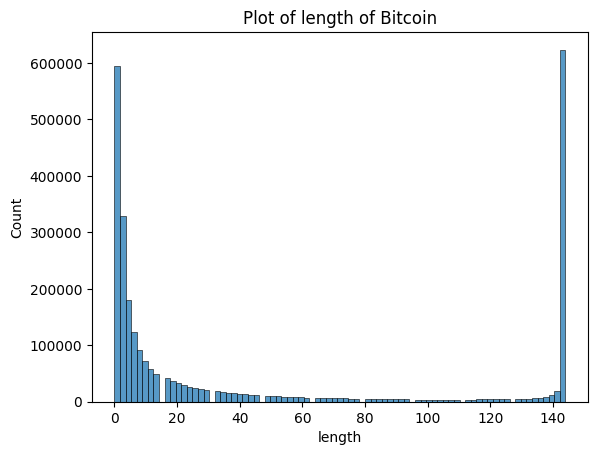

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(bit['length'], kde=False)
plt.title("Plot of length of Bitcoin")
plt.xlabel("length")

sns.histplot(bit['weight'],bins=10, kde=False)
plt.title("Plot of weight of Bitcoin")
plt.xlabel("weight")

In [12]:
from sklearn.model_selection import train_test_split

X = bit.drop('label_white', axis=1)
y = bit['label_white']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [13]:
X_train.shape

(1930732, 24)

In [14]:
X_test.shape

(827457, 24)

# Classical Models

## Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier
model_dt = DecisionTreeClassifier(random_state=1).fit(X_train, y_train)
from sklearn.metrics import classification_report
print(f"Performance on TEST\n*******************\n{classification_report(y_test, model_dt.predict(X_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model_dt.predict(X_train))}")


Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.31      0.35      0.33     10695
        True       0.99      0.99      0.99    816762

    accuracy                           0.98    827457
   macro avg       0.65      0.67      0.66    827457
weighted avg       0.98      0.98      0.98    827457

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.96      1.00      0.98     25068
        True       1.00      1.00      1.00   1905664

    accuracy                           1.00   1930732
   macro avg       0.98      1.00      0.99   1930732
weighted avg       1.00      1.00      1.00   1930732



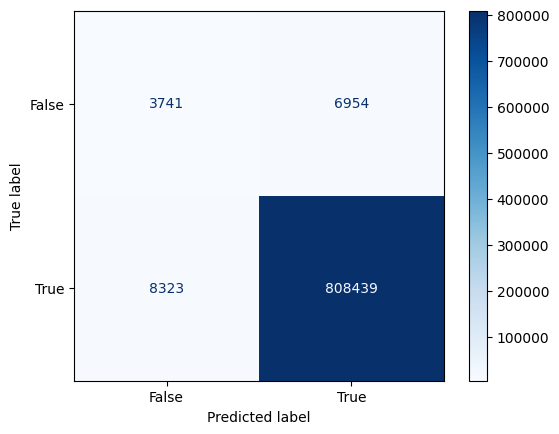

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay.from_estimator(model_dt, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# fit the LG model -- random_state is used to shuffle the data; max_iter is max # of iterations for solver to converge (default is 100)
model_lr = LogisticRegression(random_state=1, max_iter=1000,solver = 'saga').fit(X_train, y_train)
# print the report
print(f"Performance on TEST\n*******************\n{classification_report(y_test, model_lr.predict(X_test))}")
print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model_lr.predict(X_train))}")

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Performance on TEST
*******************
              precision    recall  f1-score   support

       False       0.00      0.00      0.00     10695
        True       0.99      1.00      0.99    816762

    accuracy                           0.99    827457
   macro avg       0.49      0.50      0.50    827457
weighted avg       0.97      0.99      0.98    827457

Performance on TRAIN
********************
              precision    recall  f1-score   support

       False       0.00      0.00      0.00     25068
        True       0.99      1.00      0.99   1905664

    accuracy                           0.99   1930732
   macro avg       0.49      0.50      0.50   1930732
weighted avg       0.97      0.99      0.98   1930732



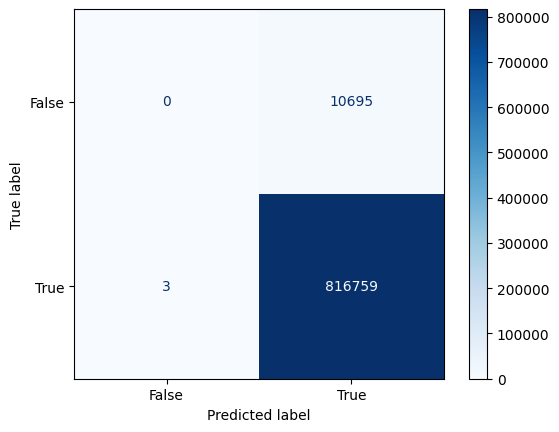

In [30]:
cm_display = ConfusionMatrixDisplay.from_estimator(model_lr, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## KNN

In [17]:
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = KNeighborsClassifier(n_neighbors=3)

# fit the model to the training set
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
### Check the accuracy on the test data
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

accuracy_test=accuracy_score(y_test, knn.predict(X_test))
print('Accuracy of knn on test data is : {:.2}'.format(accuracy_test))

# Check accuracy on the training data
accuracy_train=accuracy_score(y_train, knn.predict(X_train))
print('Accuracy of knn on train data is : {:.2}'.format(accuracy_train))

Accuracy of knn on test data is : 0.99
Accuracy of knn on train data is : 0.99


In [20]:
y_pred = knn.predict(X_test)
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"f1_score: {f1_score(y_test, y_pred)}")

Recall: 0.9972378734564047
Precision: 0.9880944293478261
f1_score: 0.9926450963449724


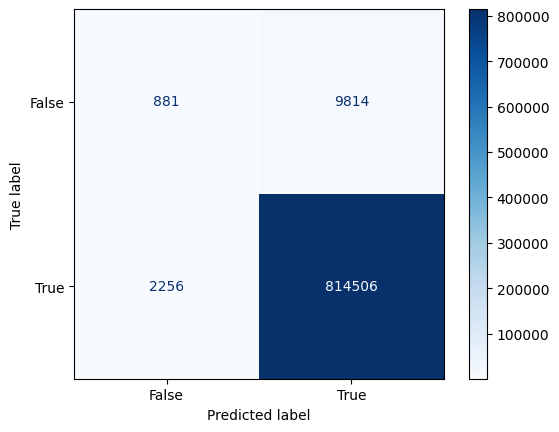

In [18]:
cm_display = ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## Random Forest (current issues)

In [24]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier()
param_grid = {
   "n_estimators": np.arange(start=10, stop=100, step=2),
   "max_depth": np.arange(start=2, stop=20),
   "min_samples_leaf": np.arange(start=1, stop=5),
   "class_weight": [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
}

gscv = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring="recall", )
gscv.fit(X_train, y_train)
gscv.best_params_"""

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV\n\nmodel = RandomForestClassifier()\nparam_grid = {\n   "n_estimators": np.arange(start=10, stop=100, step=2),\n   "max_depth": np.arange(start=2, stop=20),\n   "min_samples_leaf": np.arange(start=1, stop=5),\n   "class_weight": [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],\n}\n\ngscv = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring="recall", )\ngscv.fit(X_train, y_train)\ngscv.best_params_'

In [25]:
#from sklearn.metrics import classification_report
#print(f"Performance on TEST\n*******************\n{classification_report(y_test, model.predict(X_test))}")
#print(f"Performance on TRAIN\n********************\n{classification_report(y_train, model.predict(X_train))}")

## Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.02      0.88      0.04     10695
        True       1.00      0.45      0.62    816762

    accuracy                           0.45    827457
   macro avg       0.51      0.66      0.33    827457
weighted avg       0.98      0.45      0.61    827457



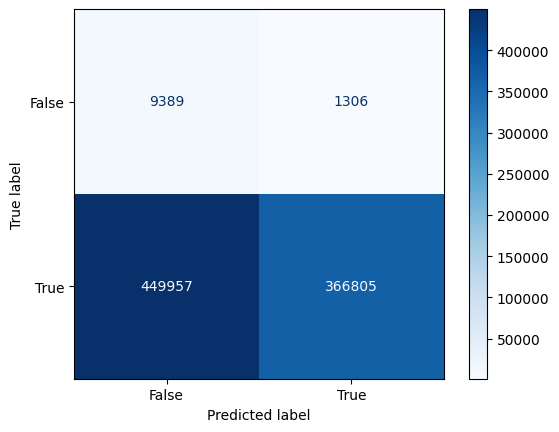

In [21]:
cm_display = ConfusionMatrixDisplay.from_estimator(gnb, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

# Advanced Classical Algorithims

## Support Vector Machine (SVC)

In [22]:
from sklearn.svm import LinearSVC, SVC
model_SVC = SVC()

In [23]:
y_pred = model_SVC.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       False       0.00      0.00      0.00     10695
        True       0.99      1.00      0.99    816762

    accuracy                           0.99    827457
   macro avg       0.49      0.50      0.50    827457
weighted avg       0.97      0.99      0.98    827457



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


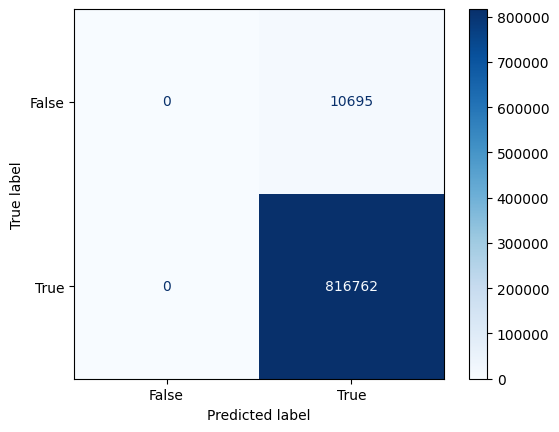

In [24]:
cm_display = ConfusionMatrixDisplay.from_estimator(model_SVC, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## Linear Support Vector Machine (LinearSVC)

In [25]:
model_LinearSVC = LinearSVC()

In [26]:
y_pred = model_LinearSVC.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,y_pred))

/usr/local/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

       False       0.01      0.03      0.02     10695
        True       0.99      0.96      0.97    816762

    accuracy                           0.95    827457
   macro avg       0.50      0.50      0.50    827457
weighted avg       0.97      0.95      0.96    827457



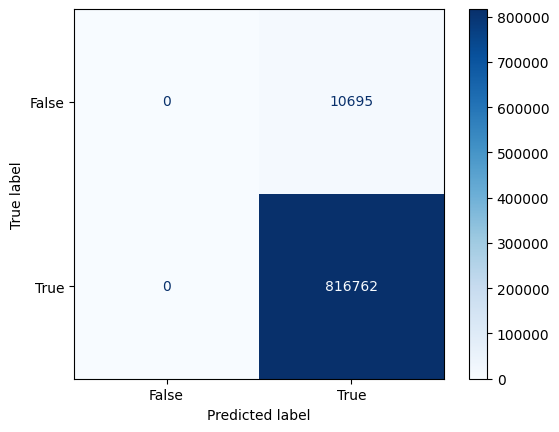

In [27]:
cm_display = ConfusionMatrixDisplay.from_estimator(model_SVC, X_test, y_test,cmap=plt.cm.Blues,normalize=None)

## TabTranformer (Transformer Model Capable of Processing Tabular Data)